In [ ]:
import os
import xarray as xr
import numpy as np

# === Path Settings ===
region = "WET"  # Change this to your region name
recovery_period = 3  # Set the recovery period (drought-free months)
input_file = r"Data - Modelling\Region_Monthly_DB\2. Reg_Combined\WET_Combined.nc"  # Change this to your file path
output_file = r"Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files\WET_Combined_Consecutive.nc"

# === Load the Combined Region File ===
ds = xr.open_dataset(input_file)
print(f"✅ Loaded Region File: {input_file}")

# === SPI Threshold and Recovery Settings ===
spi_threshold = -1.0
recovery_threshold = -0.5  # Recovery threshold (SPI ≥ -0.5)

# === Initialize Consecutive Drought Labeling (With NaNs Preserved) ===
consecutive_drought = np.full_like(ds["spi_1"].values, np.nan)
valid_mask = ~np.isnan(ds["spi_1"].values)  # Only process valid (non-NaN) values

# === Continuous Consecutive Drought Labeling ===
for lat in range(consecutive_drought.shape[1]):
    for lon in range(consecutive_drought.shape[2]):
        if not np.isnan(ds["spi_1"].values[:, lat, lon]).all():
            spi_series = ds["spi_1"][:, lat, lon]
            consecutive_series = np.zeros_like(spi_series)
            in_drought = False
            recovery_start = None

            for t in range(1, len(spi_series)):
                if np.isnan(spi_series[t]):
                    continue

                if spi_series[t] <= spi_threshold:  # Drought Detected
                    if in_drought:
                        consecutive_series[t] = 1  # Continuation of drought
                    else:
                        # New Drought - Check if within recovery period
                        if recovery_start is not None and (t - recovery_start) <= recovery_period:
                            consecutive_series[t] = 1
                        in_drought = True
                        recovery_start = None

                else:  # Not a Drought (Recovery or Normal)
                    if in_drought:
                        if spi_series[t] >= recovery_threshold:
                            recovery_start = t
                            in_drought = False

            # Apply consecutive drought label
            consecutive_drought[:, lat, lon] = consecutive_series

# === Add Consecutive Drought Label to the Dataset ===
ds["consecutive_drought"] = ("time", "lat", "lon"), np.where(valid_mask, consecutive_drought, np.nan)

# === Save the Labeled File ===
ds.to_netcdf(output_file)
print(f"✅ Saved Labeled Region File: {output_file}")


✅ Loaded Region File: Data - Modelling\Region_Monthly_DB\2. Reg_Combined\NET_Combined.nc
✅ Saved Labeled Region File: Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files_v02\NET_Combined_Consecutive.nc


In [18]:
import xarray as xr
import numpy as np
import pandas as pd

# === File and Location Settings ===
input_file = r"Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files\NET_Combined_Consecutive.nc"
lat_idx = 10  # Change as needed
lon_idx = 10

# === Drought Thresholds ===
spi_threshold = -1.0
recovery_threshold = -0.5
recovery_period = 3  # In months (adjust per region if needed)

# === Load Dataset ===
ds = xr.open_dataset(input_file)
spi_series = ds["spi_1"][:, lat_idx, lon_idx].values
consec_series = ds["consecutive_drought"][:, lat_idx, lon_idx].values
time_series = pd.to_datetime(ds["time"].values)

# === Track and Record Events ===
records = []
in_drought = False
recovery_start = None
recovery_start_idx = None
drought_start_month = None

for t in range(1, len(spi_series)):
    if np.isnan(spi_series[t]):
        continue

    if spi_series[t] <= spi_threshold:
        if not in_drought:
            if recovery_start is not None and (t - recovery_start_idx) <= recovery_period:
                # This is a consecutive drought
                records.append({
                    "Drought Start": drought_start_month.strftime("%Y-%m"),  # KEEP original
                    "Recovery Start": recovery_start.strftime("%Y-%m"),
                    "Consecutive Drought Month": time_series[t].strftime("%Y-%m")
                })
            else:
                # New independent drought
                drought_start_month = time_series[t]
            in_drought = True
            recovery_start = None
            recovery_start_idx = None
    else:
        if in_drought:
            if spi_series[t] >= recovery_threshold:
                recovery_start = time_series[t]
                recovery_start_idx = t
                in_drought = False

# === Print Table ===
df = pd.DataFrame(records)
if df.empty:
    print("No consecutive droughts detected at the selected location.")
else:
    print("\nConsecutive Drought Events at Location (lat_idx={}, lon_idx={}):".format(lat_idx, lon_idx))
    print(df.to_string(index=False))



Consecutive Drought Events at Location (lat_idx=10, lon_idx=10):
Drought Start Recovery Start Consecutive Drought Month
      2002-04        2002-05                   2002-07
      2003-05        2003-06                   2003-09
      2004-03        2004-04                   2004-06
      2007-05        2007-06                   2007-07
      2007-05        2007-08                   2007-09
      2008-03        2008-07                   2008-08
      2012-05        2012-06                   2012-08
      2015-06        2015-07                   2015-09
      2016-04        2016-05                   2016-07
      2019-04        2019-05                   2019-07
      2020-09        2020-10                   2020-11
      2021-05        2021-06                   2021-09
      2022-04        2022-05                   2022-07
      2023-04        2023-05                   2023-08
      2024-08        2024-09                   2024-10


In [ ]:
import xarray as xr

# Load the dataset
file_path = r"Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files\WET_Combined_Consecutive.nc"
ds = xr.open_dataset(file_path)

# Count of NaN values for each variable
nan_counts_per_var = ds.isnull().sum()
print("NaN count per variable:")
print(nan_counts_per_var)

NaN count per variable:
<xarray.Dataset> Size: 48B
Dimensions:              ()
Data variables:
    monthly_rain         int64 8B 64800
    max_temp             int64 8B 64800
    min_temp             int64 8B 64800
    radiation            int64 8B 64800
    spi_1                int64 8B 64800
    consecutive_drought  int64 8B 64800


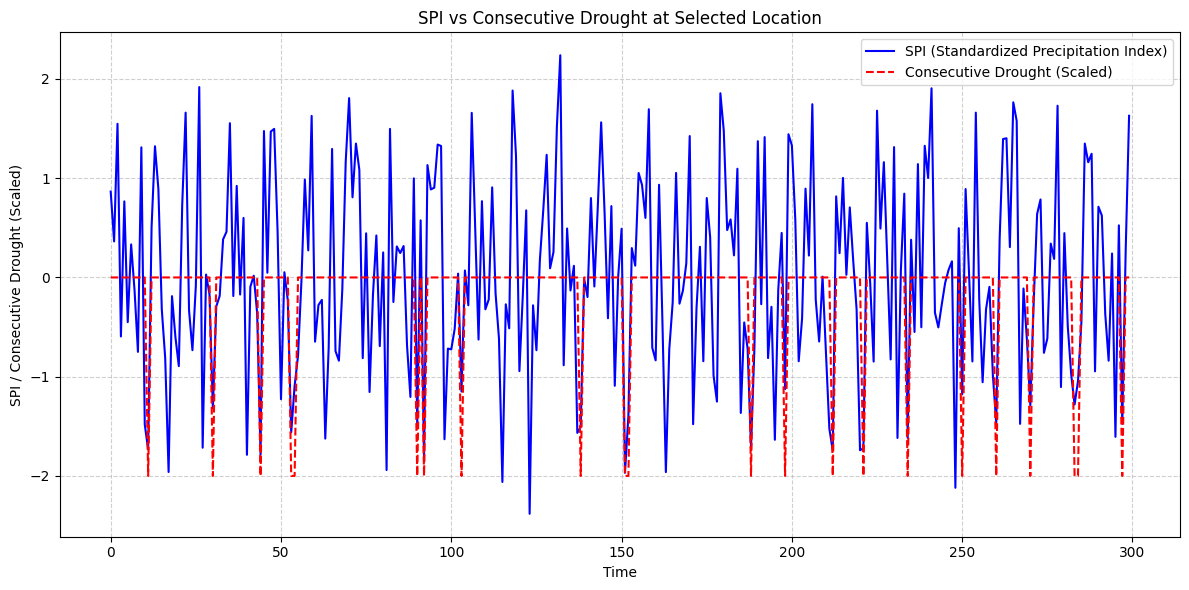

In [22]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

# === Load the Optimized Consecutive Drought Labeled File ===
input_file = r"Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files\NET_Combined_Consecutive.nc"
ds = xr.open_dataset(input_file)

# Extract SPI and Consecutive Drought Data
spi_data = ds["spi_1"].values
consecutive_drought = ds["consecutive_drought"].values

# Select a specific location (lat, lon) for visualization (adjust as needed)
lat_idx = 10  # Adjust this index for your region
lon_idx = 10  # Adjust this index for your region

# Extract time series for the selected location
spi_series = spi_data[:, lat_idx, lon_idx]
consec_series = consecutive_drought[:, lat_idx, lon_idx]

# Mask invalid values (NaNs)
valid_indices = ~np.isnan(spi_series)
spi_series = spi_series[valid_indices]
consec_series = consec_series[valid_indices]

# Plotting SPI and Consecutive Drought
plt.figure(figsize=(12, 6))
plt.plot(spi_series, label='SPI (Standardized Precipitation Index)', color='blue')
plt.plot(consec_series * -2, label='Consecutive Drought (Scaled)', color='red', linestyle='--')  # Adjust scale for visibility
plt.title('SPI vs Consecutive Drought at Selected Location')
plt.xlabel('Time')
plt.ylabel('SPI / Consecutive Drought (Scaled)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


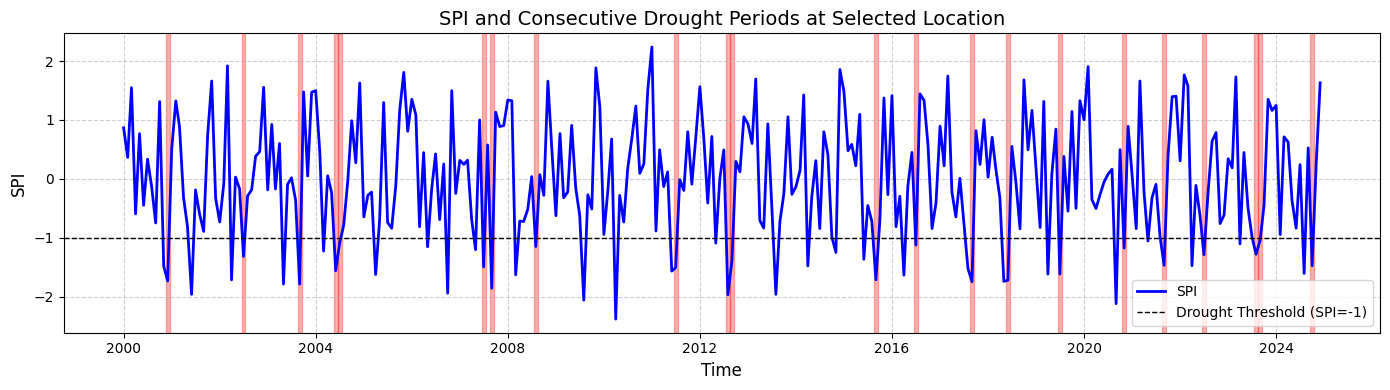

In [27]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd

# === Load the Optimized Consecutive Drought Labeled File ===
input_file = r"Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files\NET_Combined_Consecutive.nc"
ds = xr.open_dataset(input_file)

# Extract SPI and Consecutive Drought Data
spi_data = ds["spi_1"].values
consecutive_drought = ds["consecutive_drought"].values
time = pd.to_datetime(ds["time"].values)  # Convert to datetime if available


# Select a specific location (lat, lon) for visualization
lat_idx = 10
lon_idx = 10

# Extract time series
spi_series = spi_data[:, lat_idx, lon_idx]
consec_series = consecutive_drought[:, lat_idx, lon_idx]

# Mask invalid values (NaNs)
valid_mask = ~np.isnan(spi_series)
spi_series = spi_series[valid_mask]
consec_series = consec_series[valid_mask]
time = time[valid_mask]

# Plotting
fig, ax = plt.subplots(figsize=(14, 4))

# Plot SPI
ax.plot(time, spi_series, label='SPI', color='blue', linewidth=2)

# Highlight consecutive drought periods
for i in range(len(consec_series)):
    if consec_series[i] == 1:
        ax.axvspan(time[i] - pd.Timedelta(days=15), time[i] + pd.Timedelta(days=15),
                   color='red', alpha=0.3)

# Add horizontal threshold line for SPI drought threshold
ax.axhline(-1.0, color='black', linestyle='--', linewidth=1, label='Drought Threshold (SPI=-1)')

# Plot formatting
ax.set_title('SPI and Consecutive Drought Periods at Selected Location', fontsize=14)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('SPI', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()
plt.tight_layout()
plt.show()


✅ Loaded Labeled Region File: Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files\NET_Combined_Consecutive.nc


C:\Users\Jspch\AppData\Local\Temp\ipykernel_19752\2296640183.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


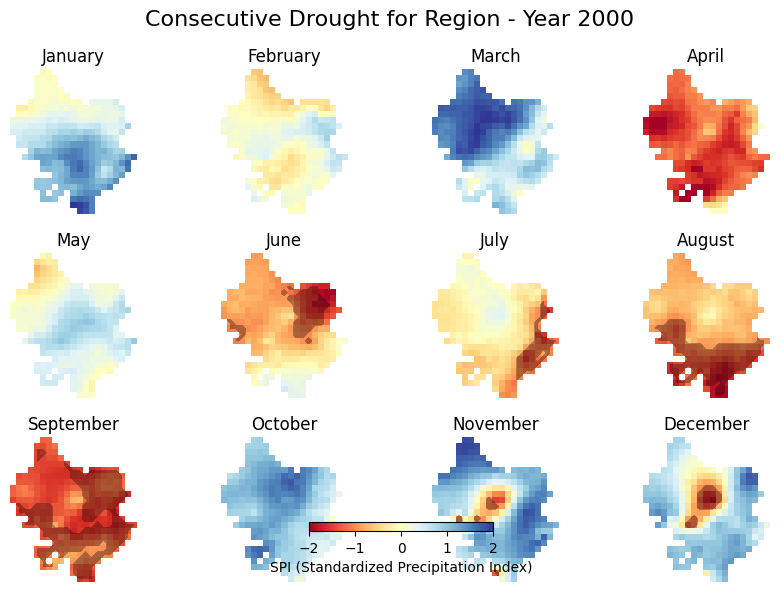

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# === Load the Labeled Region File ===
labeled_file = r"Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files\NET_Combined_Consecutive.nc"  # Change this to your file path
ds = xr.open_dataset(labeled_file)
print("✅ Loaded Labeled Region File:", labeled_file)

# === Select the first year for visualization ===
first_year = ds.time.dt.year[0].item()
year_data = ds.sel(time=str(first_year))

# === Visualization Setup ===
fig, axes = plt.subplots(3, 4, figsize=(9, 6))
fig.suptitle(f"Consecutive Drought for Region - Year {first_year}", fontsize=16)

# === Plot SPI + Consecutive Drought Overlay for Each Month ===
for i, month in enumerate(year_data.time[:12]):
    ax = axes[i // 4, i % 4]
    month_data = year_data.sel(time=month)

    # === Plot SPI ===
    spi = month_data["spi_1"].values
    spi_masked = np.ma.masked_where(np.isnan(spi), spi)

    spi_plot = ax.imshow(spi_masked, cmap="RdYlBu", vmin=-2, vmax=2)
    ax.set_title(str(month.dt.strftime('%B').item()))
    ax.axis('off')

    # === Overlay Consecutive Droughts ===
    consecutive = month_data["consecutive_drought"].values
    ax.contourf(consecutive, levels=[0.5, 1], colors='black', alpha=0.3)

# === Colorbar (SPI) ===
cbar = fig.colorbar(spi_plot, ax=axes, orientation="horizontal", fraction=0.02, pad=0.05)
cbar.set_label("SPI (Standardized Precipitation Index)")

plt.tight_layout()
plt.show()


✅ Loaded Labeled Region File: Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files\CYP_Combined_Consecutive.nc


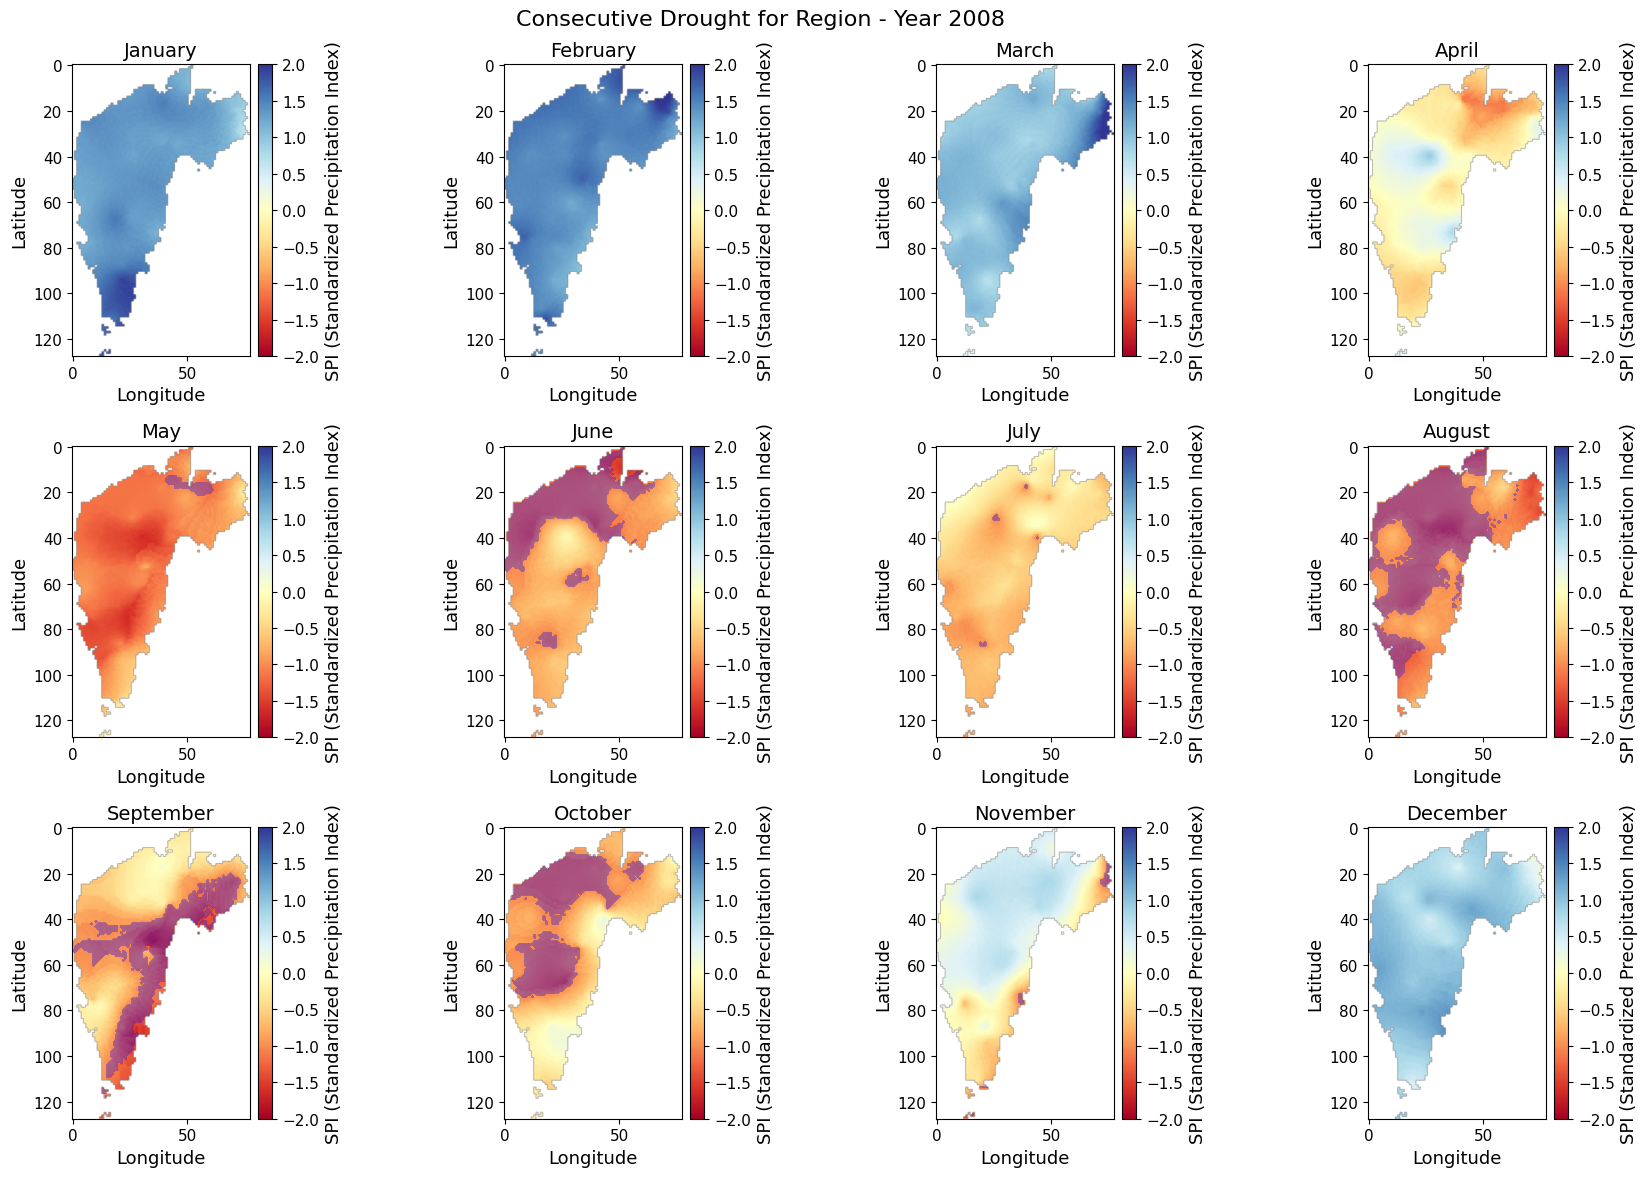

In [13]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# === Load the Labeled Region File ===
labeled_file = r"Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files\CYP_Combined_Consecutive.nc"  # Change this to your file path
ds = xr.open_dataset(labeled_file)
print("✅ Loaded Labeled Region File:", labeled_file)

# === Select the first year for visualization ===
first_year = ds.time.dt.year[107].item()
year_data = ds.sel(time=str(first_year))

# === Visualization Setup ===
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
fig.suptitle(f"Consecutive Drought for Region - Year {first_year}", fontsize=16)

# === Plot SPI + Consecutive Drought Overlay for Each Month ===
for i, month in enumerate(year_data.time[:12]):
    ax = axes[i // 4, i % 4]
    month_data = year_data.sel(time=month)

    # === Plot SPI ===
    spi = month_data["spi_1"].values
    spi_masked = np.ma.masked_where(np.isnan(spi), spi)

    spi_plot = ax.imshow(spi_masked, cmap="RdYlBu", vmin=-2, vmax=2)
    ax.set_title(str(month.dt.strftime('%B').item()))

    # Axis labels
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # === Overlay Consecutive Droughts ===
    consecutive = month_data["consecutive_drought"].values
    ax.contourf(consecutive, levels=[0.5, 1], colors='blue', alpha=0.3)

    # === Colorbar (SPI) for each subplot ===
    cbar = fig.colorbar(spi_plot, ax=ax, orientation="vertical", fraction=0.05, pad=0.02)
    cbar.set_label("SPI (Standardized Precipitation Index)")

plt.tight_layout()
plt.show()


✅ Loaded Labeled Region File: Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files\CYP_Combined_Consecutive.nc


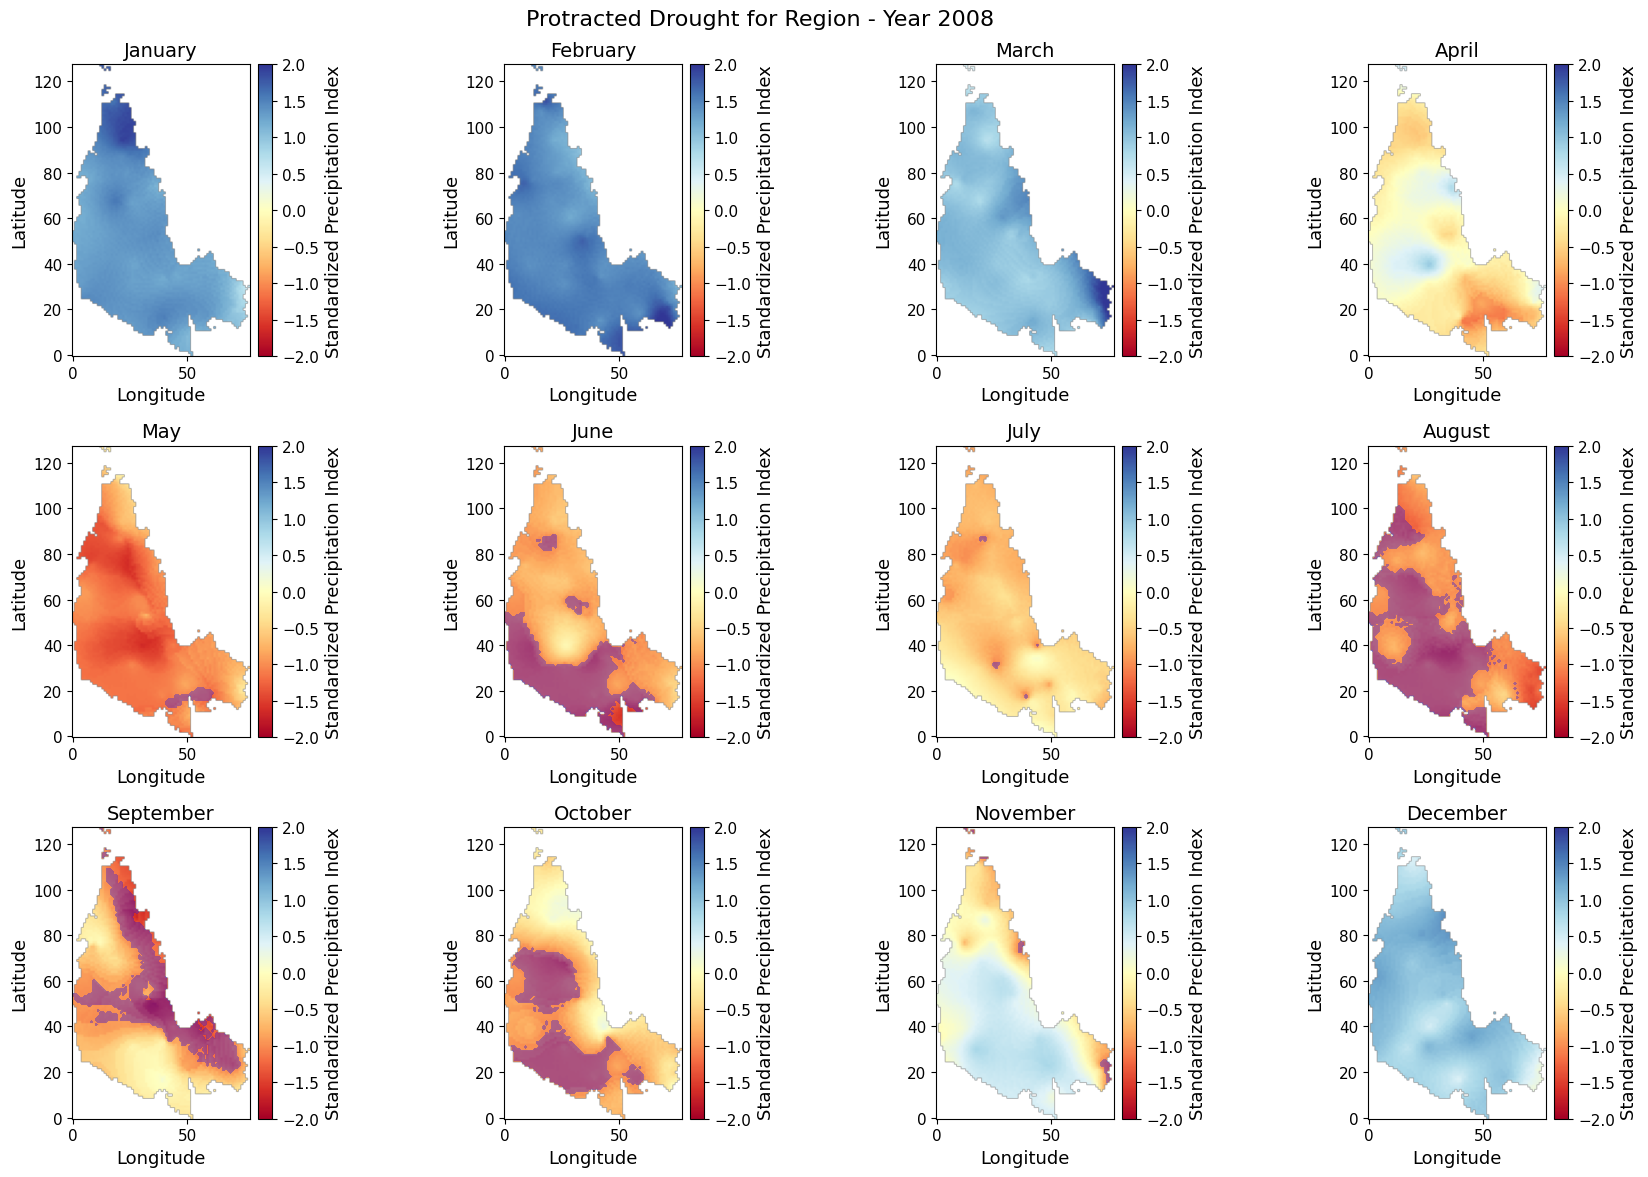

In [25]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# === Load the Labeled Region File ===
labeled_file = r"Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files\CYP_Combined_Consecutive.nc"
ds = xr.open_dataset(labeled_file)
print("✅ Loaded Labeled Region File:", labeled_file)

# === Select the first year for visualization ===
first_year = ds.time.dt.year[107].item()
year_data = ds.sel(time=str(first_year))

# === Visualization Setup ===
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
fig.suptitle(f"Protracted Drought for Region - Year {first_year}", fontsize=16)

# === Plot SPI + Consecutive Drought Overlay for Each Month ===
for i, month in enumerate(year_data.time[:12]):
    ax = axes[i // 4, i % 4]
    month_data = year_data.sel(time=month)

    # === Plot SPI ===
    spi = month_data["spi_1"].values
    spi_masked = np.ma.masked_where(np.isnan(spi), spi)

    spi_plot = ax.imshow(
        spi_masked,
        cmap="RdYlBu",
        vmin=-2,
        vmax=2,
        origin="lower"     # ✅ FIX: Correct orientation
    )

    ax.set_title(str(month.dt.strftime('%B').item()))
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # === Overlay Consecutive Drought Areas ===
    consecutive = month_data["consecutive_drought"].values
    ax.contourf(consecutive, levels=[0.5, 1], colors='blue', alpha=0.3)

    # === Colorbar ===
    cbar = fig.colorbar(spi_plot, ax=ax, orientation="vertical", fraction=0.05, pad=0.02)
    cbar.set_label("Standardized Precipitation Index")

plt.tight_layout()
plt.show()


✅ Loaded Labeled Region File: Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files\CYP_Combined_Consecutive.nc


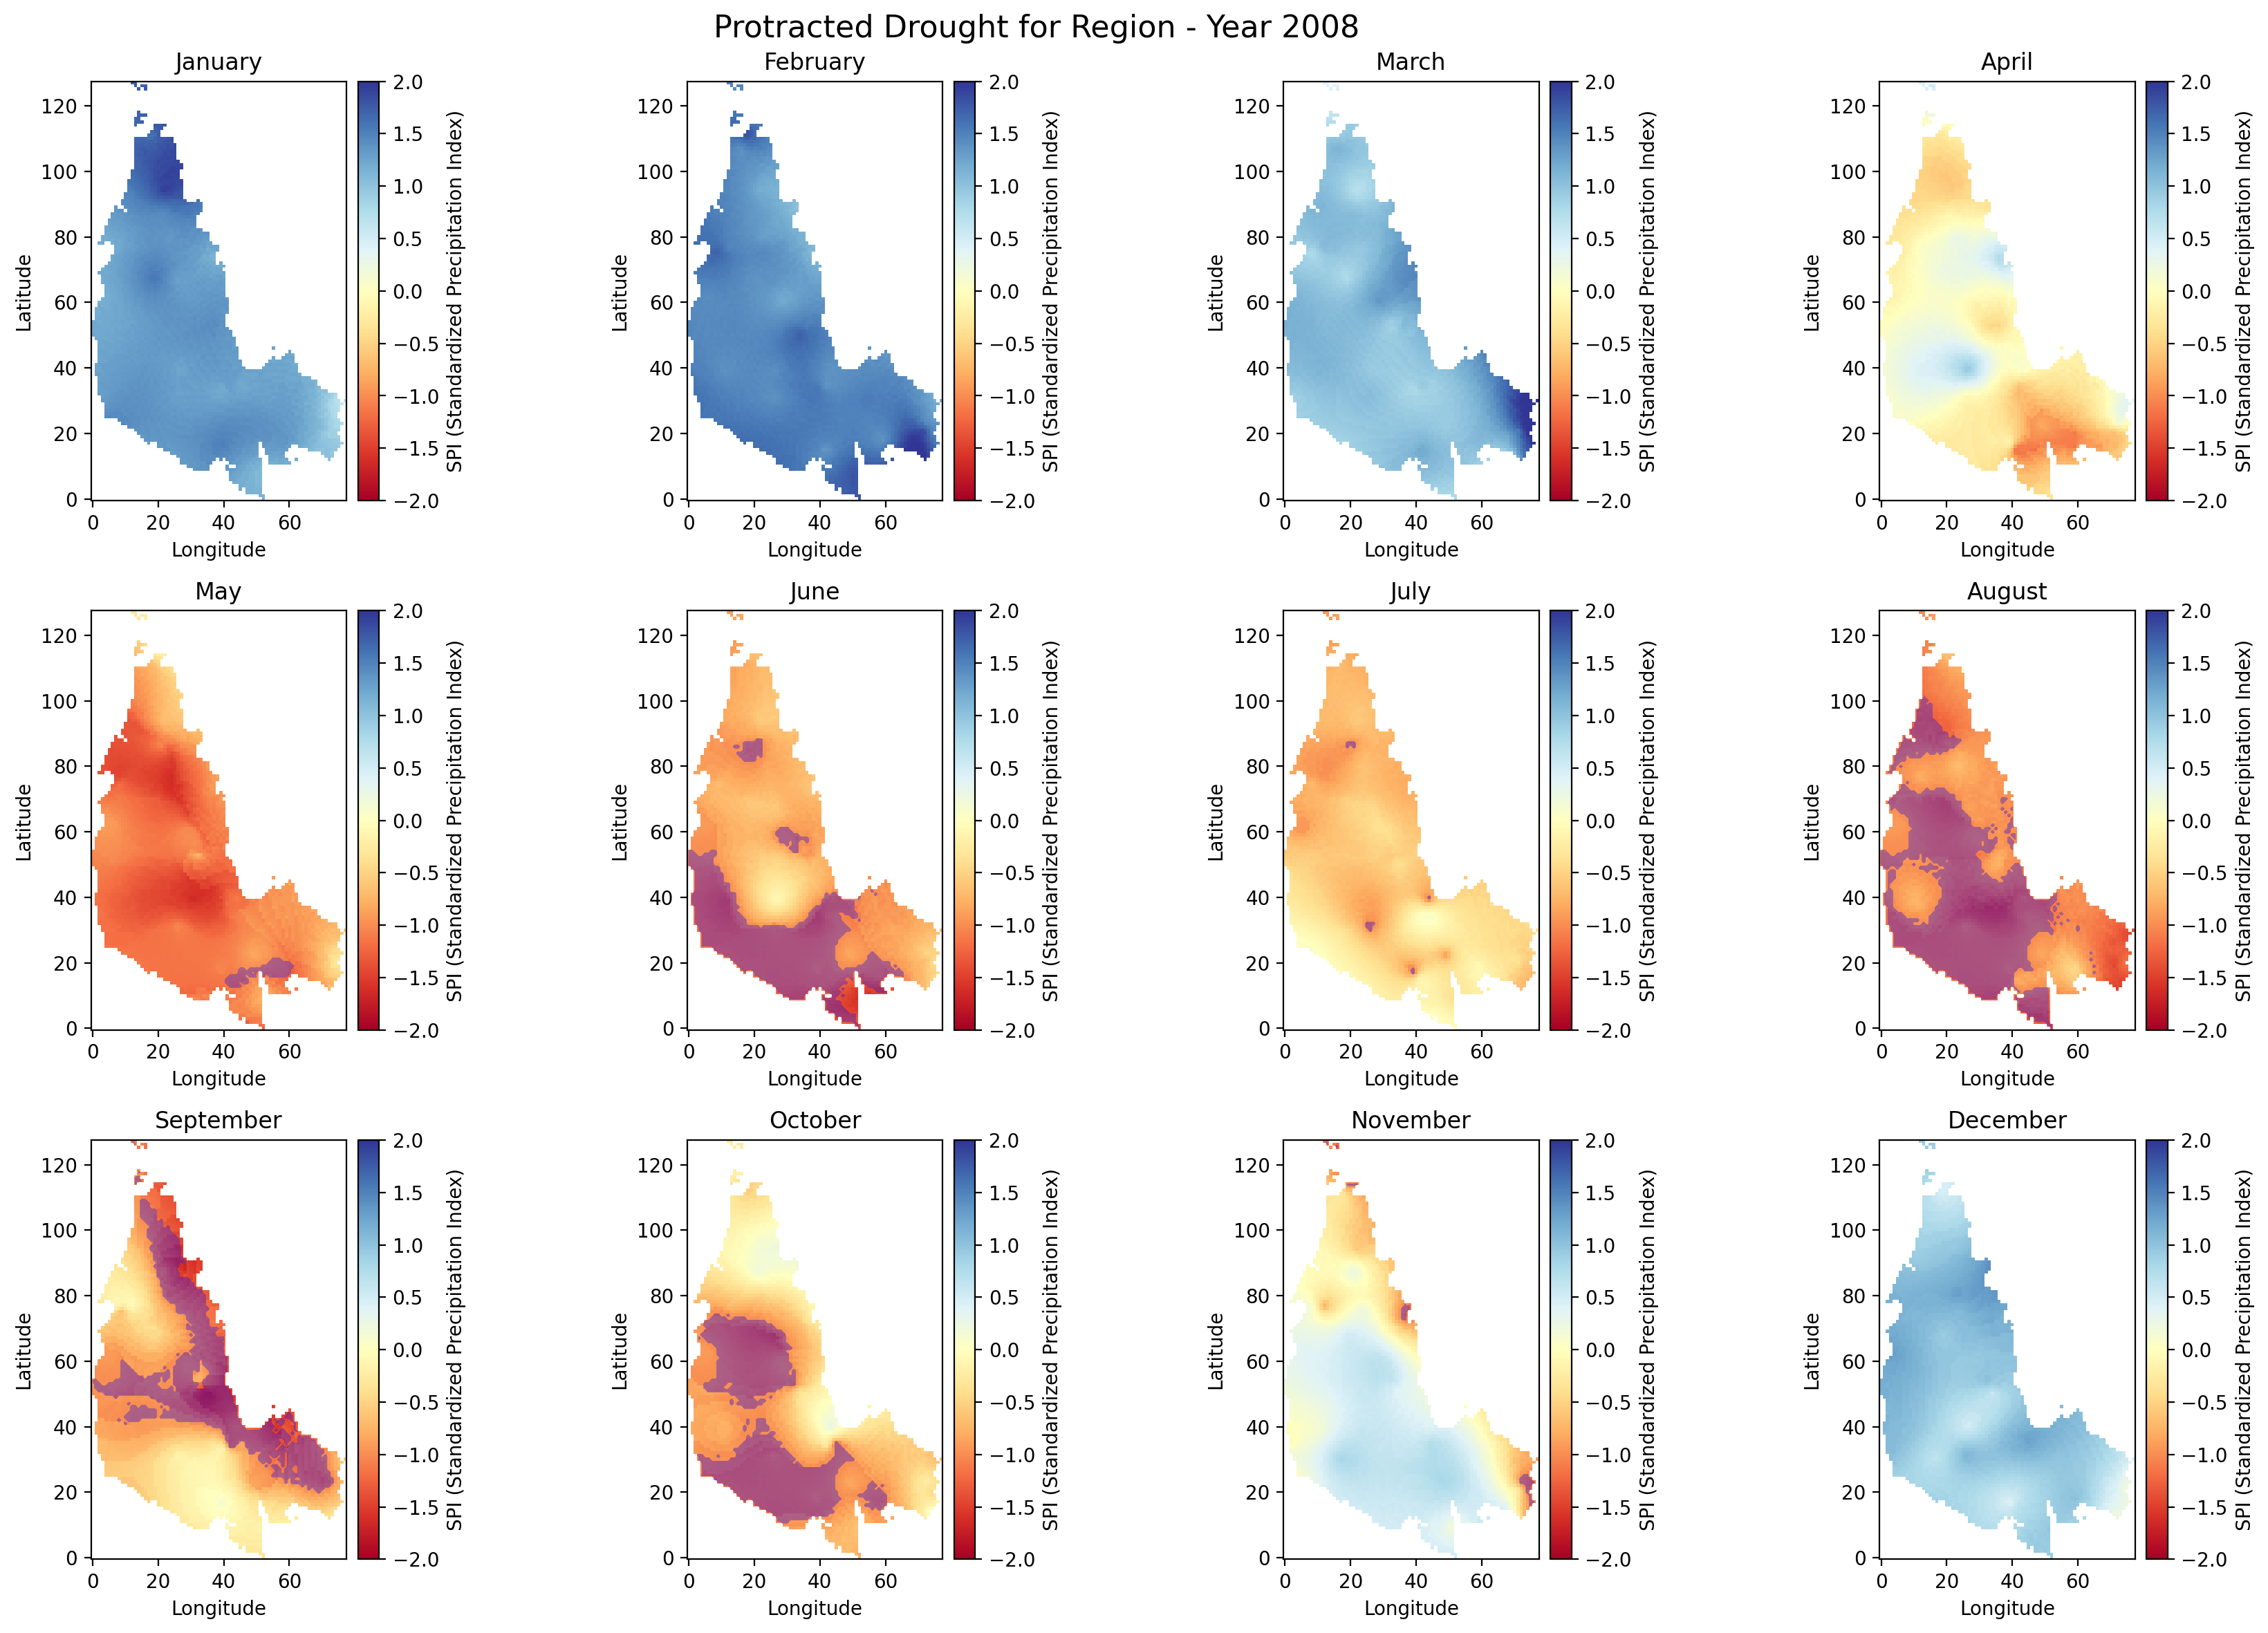

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# === Load the Labeled Region File ===
labeled_file = r"Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files\CYP_Combined_Consecutive.nc"  # Change this to your file path
ds = xr.open_dataset(labeled_file)
print("✅ Loaded Labeled Region File:", labeled_file)

# === Select the first year for visualization ===
first_year = ds.time.dt.year[107].item()
year_data = ds.sel(time=str(first_year))

# === Visualization Setup ===
fig, axes = plt.subplots(3, 4, figsize=(18, 12), dpi=200)
fig.suptitle(f"Protracted Drought for Region - Year {first_year}", fontsize=16)

# === Plot SPI + Consecutive Drought Overlay for Each Month ===
for i, month in enumerate(year_data.time[:12]):
    ax = axes[i // 4, i % 4]
    month_data = year_data.sel(time=month)

    # === Plot SPI ===
    spi = month_data["spi_1"].values
    spi_masked = np.ma.masked_where(np.isnan(spi), spi)

    # Flip orientation
    spi_plot = ax.imshow(spi_masked, cmap="RdYlBu", vmin=-2, vmax=2, origin="lower")
    ax.set_title(str(month.dt.strftime('%B').item()))

    # Axis labels
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # === Overlay Consecutive Droughts ===
    consecutive = month_data["consecutive_drought"].values
    ax.contourf(consecutive, levels=[0.5, 1], colors='blue', alpha=0.3)

    # === Colorbar (SPI) for each subplot ===
    cbar = fig.colorbar(spi_plot, ax=ax, orientation="vertical", fraction=0.05, pad=0.02)
    cbar.set_label("SPI (Standardized Precipitation Index)")

plt.tight_layout()
plt.show()


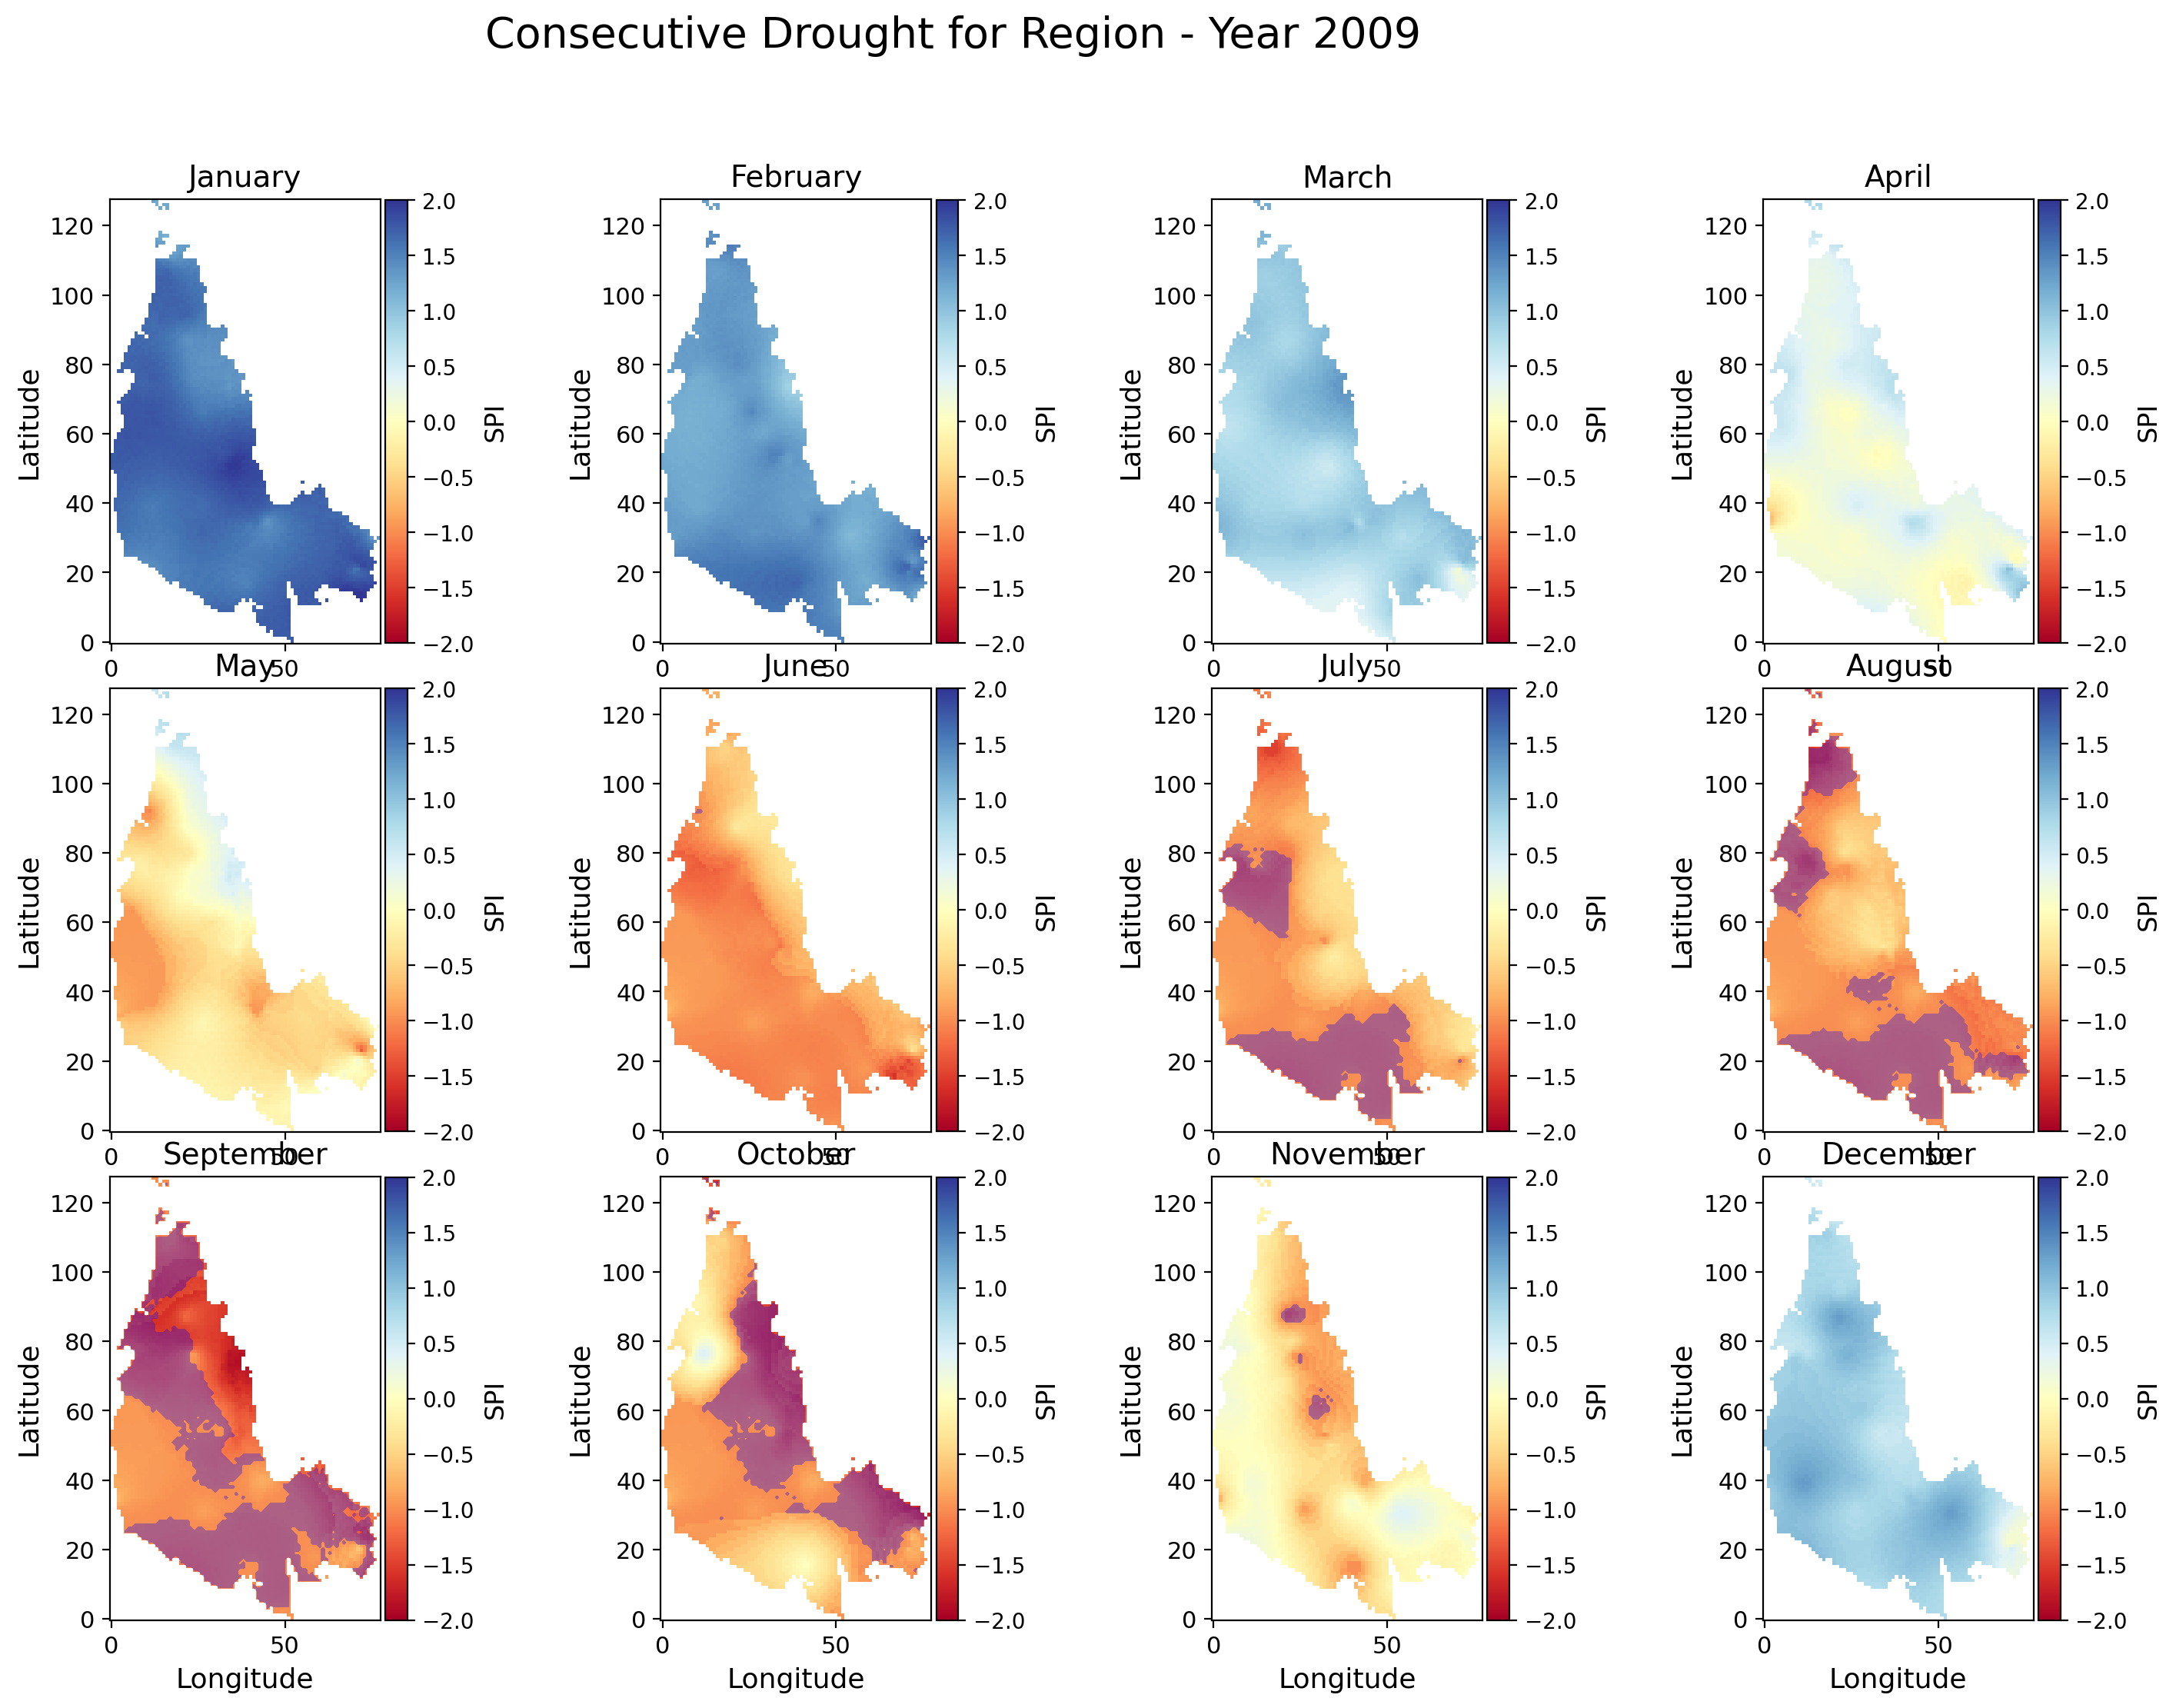

In [12]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# Increase fonts
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['figure.titlesize'] = 20

labeled_file = r"Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files\CYP_Combined_Consecutive.nc"
ds = xr.open_dataset(labeled_file)

first_year = ds.time.dt.year[108].item()
year_data = ds.sel(time=str(first_year))

fig, axes = plt.subplots(
    3, 4,
    figsize=(18, 12),
    dpi=200,
    gridspec_kw={'hspace': 0.1, 'wspace': 0.12}
)

fig.suptitle(f"Consecutive Drought for Region - Year {first_year}", fontsize=20)

for i, month in enumerate(year_data.time[:12]):
    ax = axes[i // 4, i % 4]
    month_data = year_data.sel(time=month)

    spi = month_data["spi_1"].values
    spi_masked = np.ma.masked_where(np.isnan(spi), spi)
    spi_plot = ax.imshow(spi_masked, cmap="RdYlBu", vmin=-2, vmax=2, origin="lower")

    ax.set_title(str(month.dt.strftime('%B').item()), fontsize=14)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # Overlay consecutive drought
    consecutive = month_data["consecutive_drought"].values
    ax.contourf(consecutive, levels=[0.5, 1], colors='blue', alpha=0.3)

    # ✅ Region border (auto-detect mask)
    for mask_var in ['mask', 'region_mask', 'land_mask', 'border']:
        if mask_var in month_data:
            mask = month_data[mask_var].values
            ax.contour(mask, levels=[0.5], colors='black', linewidths=0.9)
            break

    # Colorbar
    cbar = fig.colorbar(spi_plot, ax=ax, orientation="vertical", fraction=0.045, pad=0.01)
    cbar.set_label("SPI", fontsize=12)
    cbar.ax.tick_params(labelsize=10)

plt.show()


✅ Loaded Labeled Region File: Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files\CYP_Combined_Consecutive.nc


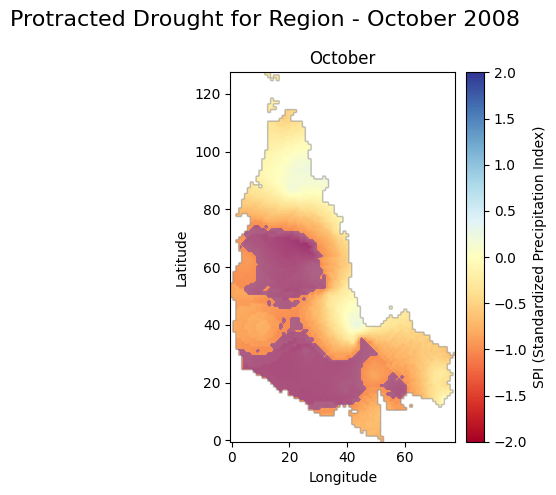

In [21]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# === Load the Labeled Region File ===
labeled_file = r"Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files\CYP_Combined_Consecutive.nc"
ds = xr.open_dataset(labeled_file)
print("✅ Loaded Labeled Region File:", labeled_file)

# === Select the first year for visualization ===
first_year = ds.time.dt.year[107].item()
year_data = ds.sel(time=str(first_year))

# ✅ Choose specific month (0=January, 1=February, ... 11=December)
month_index = 9     # example: April
month = year_data.time[month_index]

# === Single subplot instead of 3x4 ===
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
fig.suptitle(f"Protracted Drought for Region - {month.dt.strftime('%B %Y').item()}", fontsize=16)

# === Plot SPI ===
month_data = year_data.sel(time=month)
spi = month_data["spi_1"].values
spi_masked = np.ma.masked_where(np.isnan(spi), spi)

spi_plot = ax.imshow(spi_masked, cmap="RdYlBu", vmin=-2, vmax=2, origin="lower")
ax.set_title(str(month.dt.strftime('%B').item()))
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# === Overlay consecutive drought ===
consecutive = month_data["consecutive_drought"].values
ax.contourf(consecutive, levels=[0.5, 1], colors='blue', alpha=0.3)

# === Colorbar ===
cbar = fig.colorbar(spi_plot, ax=ax, orientation="vertical", fraction=0.05, pad=0.02)
cbar.set_label("SPI (Standardized Precipitation Index)")

plt.tight_layout()
plt.show()

✅ Loaded Labeled Region File: Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files\CYP_Combined_Consecutive.nc


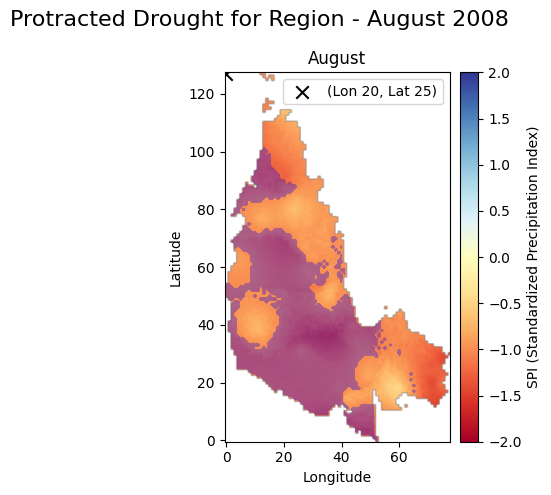

In [20]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# === Load the Labeled Region File ===
labeled_file = r"Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files\CYP_Combined_Consecutive.nc"
ds = xr.open_dataset(labeled_file)
print("✅ Loaded Labeled Region File:", labeled_file)

# === Select the first year for visualization ===
first_year = ds.time.dt.year[107].item()
year_data = ds.sel(time=str(first_year))

# ✅ Choose specific month (0=January, 1=February, ... 11=December)
month_index = 7
month = year_data.time[month_index]

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
fig.suptitle(f"Protracted Drought for Region - {month.dt.strftime('%B %Y').item()}", fontsize=16)

month_data = year_data.sel(time=month)
spi = month_data["spi_1"].values
spi_masked = np.ma.masked_where(np.isnan(spi), spi)

spi_plot = ax.imshow(spi_masked, cmap="RdYlBu", vmin=-2, vmax=2, origin="lower")
ax.set_title(str(month.dt.strftime('%B').item()))
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# === Overlay consecutive drought ===
consecutive = month_data["consecutive_drought"].values
ax.contourf(consecutive, levels=[0.5, 1], colors='blue', alpha=0.3)

# ✅ Find correct grid cell for lat=25, lon=20 (if coords exist)
if "lat" in ds and "lon" in ds:
    lat_idx = np.abs(ds.lat - 25).argmin().item()
    lon_idx = np.abs(ds.lon - 20).argmin().item()
    ax.scatter(lon_idx, lat_idx, s=80, c="black", marker="x", label="(Lon 20, Lat 25)")
else:
    # fallback: assume image coordinates
    ax.scatter(20, 25, s=80, c="black", marker="x", label="(20, 25)")

ax.legend()

cbar = fig.colorbar(spi_plot, ax=ax, orientation="vertical", fraction=0.05, pad=0.02)
cbar.set_label("SPI (Standardized Precipitation Index)")

plt.tight_layout()
plt.show()


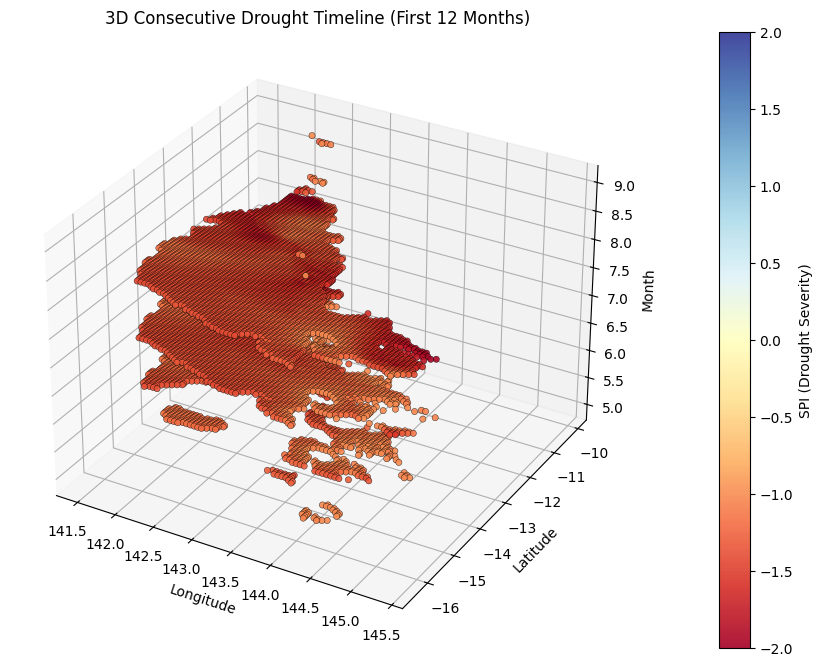

In [47]:
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Load dataset
labeled_file = r"Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files\CYP_Combined_Consecutive.nc"
ds = xr.open_dataset(labeled_file)

# Get lon, lat, time
lon = ds.lon.values
lat = ds.lat.values
time = ds.time.values

# Use only first 12 months
time = time[:12]
ds = ds.sel(time=time)

# Build meshgrid for lat/lon
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Initialize lists for 3D scatter data
x_lons = []
y_lats = []
z_times = []
colors_spi = []

# Iterate over 12 time steps
for t_index, t in enumerate(time):
    spi = ds["spi_1"].isel(time=t_index).values
    consecutive = ds["consecutive_drought"].isel(time=t_index).values

    # Find indices where drought occurred
    mask = (consecutive == 1) & (~np.isnan(spi))

    # Extract coordinates and SPI
    x_lons.extend(lon_grid[mask])
    y_lats.extend(lat_grid[mask])
    z_times.extend([t_index] * np.sum(mask))
    colors_spi.extend(spi[mask])  # Use SPI as drought severity (can change to SSI or DI)

# Convert to numpy arrays
x_lons = np.array(x_lons)
y_lats = np.array(y_lats)
z_times = np.array(z_times)
colors_spi = np.array(colors_spi)

# Plotting in 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create scatter plot
sc = ax.scatter(x_lons, y_lats, z_times, c=colors_spi, cmap="RdYlBu", vmin=-2, vmax=2, edgecolors='k', linewidths=0.3, alpha=0.9)

# Labels and axis setup
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Month")
ax.set_title("3D Consecutive Drought Timeline (First 12 Months)")

# Add colorbar
cb = plt.colorbar(sc, pad=0.1)
cb.set_label("SPI (Drought Severity)")

plt.show()


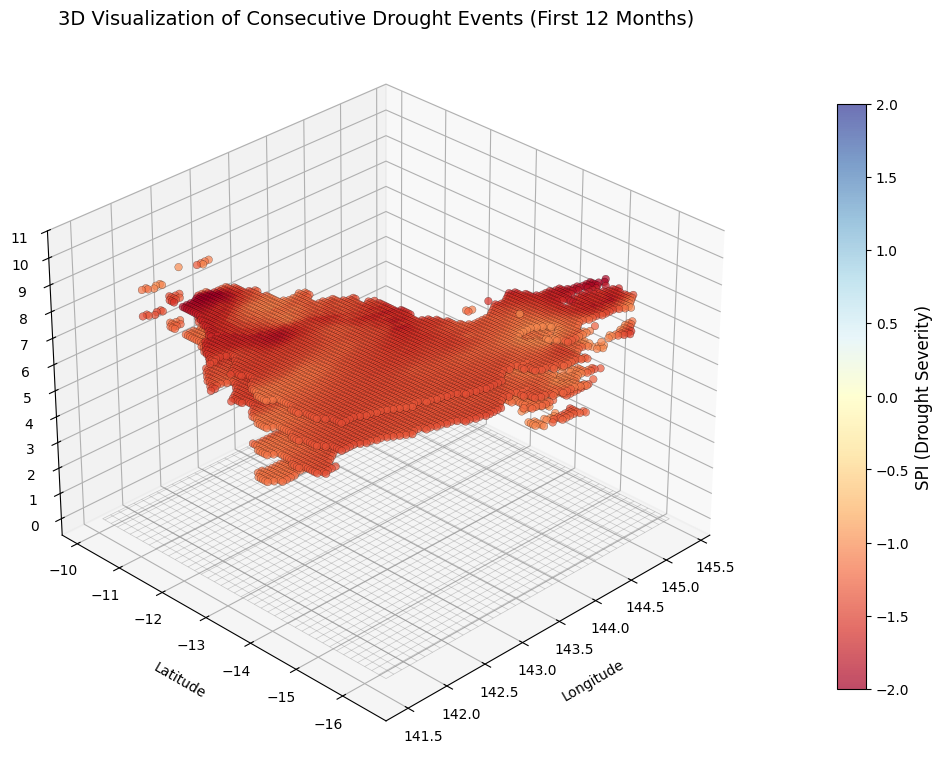

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Load dataset
labeled_file = r"Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files\CYP_Combined_Consecutive.nc"
ds = xr.open_dataset(labeled_file)

# Extract coordinate and time information
lon = ds.lon.values
lat = ds.lat.values
time = ds.time.values[:12]  # First 12 months
ds = ds.sel(time=time)

# Meshgrid for boundary plotting
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Prepare drought points
x_lons, y_lats, z_times, colors_spi = [], [], [], []

for t_index, t in enumerate(time):
    spi = ds["spi_1"].isel(time=t_index).values
    consecutive = ds["consecutive_drought"].isel(time=t_index).values

    # Mask for valid drought events
    mask = (consecutive == 1) & (~np.isnan(spi))

    # Coordinates of drought pixels
    x_lons.extend(lon_grid[mask])
    y_lats.extend(lat_grid[mask])
    z_times.extend([t_index] * np.sum(mask))
    colors_spi.extend(spi[mask])

# Convert to arrays
x_lons = np.array(x_lons)
y_lats = np.array(y_lats)
z_times = np.array(z_times)
colors_spi = np.array(colors_spi)

# === 3D Plot ===
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111, projection='3d')

# 3D scatter: Drought events
sc = ax.scatter(x_lons, y_lats, z_times, c=colors_spi, cmap="RdYlBu",
                vmin=-2, vmax=2, s=30, edgecolors='k', linewidths=0.2, alpha=0.7)

# Region boundary wireframe (z=bottom layer)
ax.plot_wireframe(lon_grid, lat_grid, np.zeros_like(lon_grid), color='gray', linewidth=0.5, alpha=0.4)

# Axis labels and ticks
ax.set_xlabel("Longitude", labelpad=10)
ax.set_ylabel("Latitude", labelpad=10)
ax.set_zlabel("Month Index", labelpad=10)
ax.set_zticks(range(12))
ax.set_title("3D Visualization of Consecutive Drought Events (First 12 Months)", fontsize=14)

# View and grid
ax.view_init(elev=30, azim=225)
ax.grid(True)

# Colorbar
cb = plt.colorbar(sc, ax=ax, shrink=0.5, pad=0.1)
cb.set_label("SPI (Drought Severity)", fontsize=12)

plt.tight_layout()
plt.show()


C:\Users\Jspch\AppData\Local\Temp\ipykernel_24456\1034929865.py:79: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


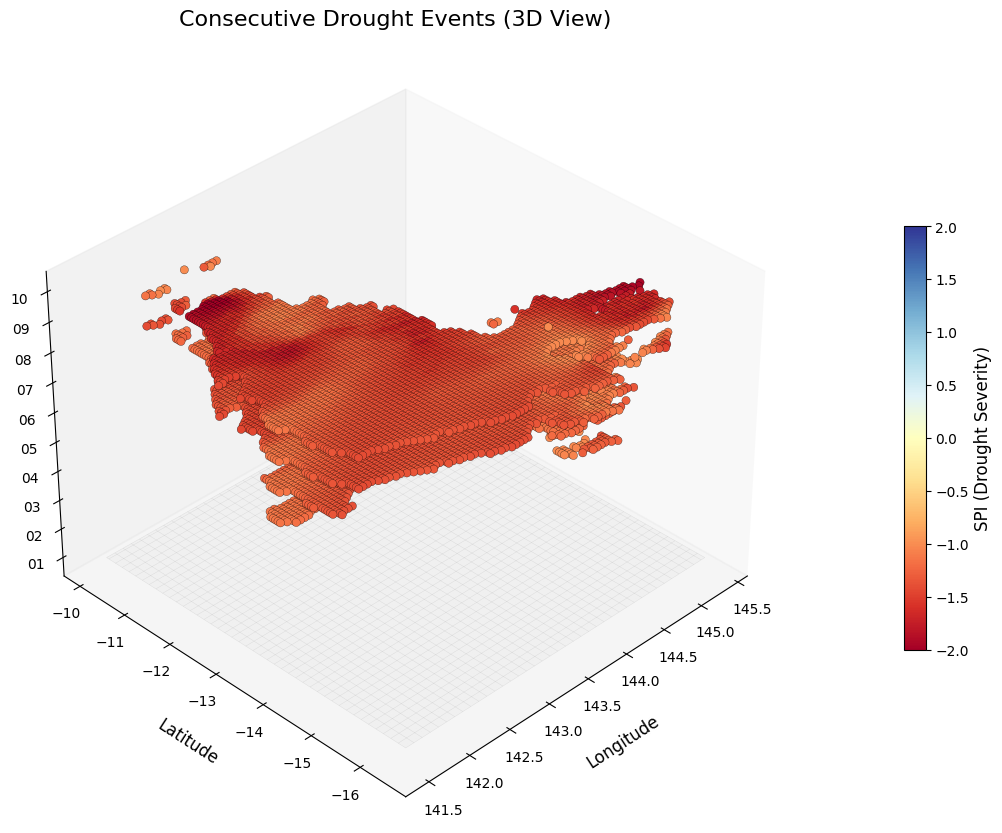

In [49]:
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import cm

# Load dataset
labeled_file = r"Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files\CYP_Combined_Consecutive.nc"
ds = xr.open_dataset(labeled_file)

# Get coordinates and time
lon = ds.lon.values
lat = ds.lat.values
time = ds.time.values[:12]
ds = ds.sel(time=time)

lon_grid, lat_grid = np.meshgrid(lon, lat)

# Collect drought points
x_lons, y_lats, z_times, colors_spi = [], [], [], []

for t_index, t in enumerate(time):
    spi = ds["spi_1"].isel(time=t_index).values
    consecutive = ds["consecutive_drought"].isel(time=t_index).values
    mask = (consecutive == 1) & (~np.isnan(spi))

    x_lons.extend(lon_grid[mask])
    y_lats.extend(lat_grid[mask])
    z_times.extend([t_index] * np.sum(mask))
    colors_spi.extend(spi[mask])

# Convert to arrays
x_lons = np.array(x_lons)
y_lats = np.array(y_lats)
z_times = np.array(z_times)
colors_spi = np.array(colors_spi)

# Plot
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

# Stylish scatter
scatter = ax.scatter(
    x_lons, y_lats, z_times,
    c=colors_spi,
    cmap="RdYlBu", vmin=-2, vmax=2,
    s=35, edgecolor='black', linewidth=0.2, alpha=1.0
)

# Transparent floor grid
ax.plot_surface(
    lon_grid, lat_grid, np.zeros_like(lon_grid),
    color='lightgray', alpha=0.05, zorder=0, rstride=1, cstride=1
)

# Clean axis setup
ax.set_xlabel("Longitude", labelpad=12, fontsize=12)
ax.set_ylabel("Latitude", labelpad=12, fontsize=12)
ax.set_zlabel("Month", labelpad=10, fontsize=12)

month_labels = [np.datetime_as_string(t, unit='M')[-2:] for t in time]
ax.set_zticks(range(12))
ax.set_zticklabels(month_labels)

# Aesthetic tweaks
ax.view_init(elev=35, azim=225)
ax.set_title("Consecutive Drought Events (3D View)", fontsize=16, pad=20)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(False)

# Region boundary wireframe (z=bottom layer)
ax.plot_wireframe(lon_grid, lat_grid, np.zeros_like(lon_grid), color='gray', linewidth=0.3, alpha=0.2)

# Colorbar
cb = plt.colorbar(scatter, ax=ax, shrink=0.55, pad=0.1)
cb.set_label("SPI (Drought Severity)", fontsize=12)
cb.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()
